## Mask R-CNN - Simulate the `Detection Layer` Process for COCO images

We generate the inputs to `DetectTargetLayer` , to manipulate and modify the layer to procduce a modified `output_rois` 
containing false positives. 
This will be passed on the the heatmap layer, and through there will become the input to FCN.

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen         import data_generator, load_image_gt
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
import mrcnn.visualize as visualize
from   mrcnn.prep_notebook   import mrcnn_coco_test
import mrcnn.utils as utils
from   mrcnn.utils import log
import pprint

pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)
###  Build model in Inference mode

mrcnn_model, dataset_test, test_generator, mrcnn_config = mrcnn_coco_test(mode='inference')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>>> Initialize ModelBase model 
   Mode:  inference
   Model dir :  /users/students/r0653928/models/train_mrcnn_coco
>>> ModelBase initialiation complete
>>> ---Initialize MRCNN model, mode:  inference

----------------------------
>>> Resnet Graph 
----------------------------
     Input_image shape : (?, 1024, 1024, 3)
     After ZeroPadding2D  : (?, 1030, 1030, 3) (?, 1030, 1030, 3)
     After Conv2D padding : (?, 512, 512, 64) (?, 512, 512, 64)
     After BatchNorm      : (?, 512, 512, 64) (?, 512, 512, 64)
     C1 Shape: (?, 256, 256, 64) (?, 256, 256, 64)
     C2 Shape:  (?, 256, 256, 256) (?, 256, 256, 256)
     C3 Shape:  (?, 128, 128, 512) (?, 128, 128, 512)
     C4 Shape:  (?, 64, 64, 1024) (?, 64, 64, 1024)
     C5 Shape:  (?, 32, 32, 2048) (?, 32, 32, 2048)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 256, 256, 256)
     FPN P3 shape : (None, 128, 128, 256)
     F

#### Load weights

In [4]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
exclude = None
mrcnn_model.load_model_weights(init_with = 'last', exclude = exclude)  

-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  /users/students/r0653928/models/train_mrcnn_coco
 Key : > mrcnn <
 Dir names:  ['mrcnn20181012T1227', 'mrcnn20181011T1730', 'mrcnn20181013T1338', 'mrcnn20181014T1422', 'mrcnn20181011T2049']
 Folder:  /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181014T1422  Checkpoints:  []
 Folder:  /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338  Checkpoints:  ['mrcnn_0011.h5', 'mrcnn_0026.h5', 'mrcnn_0027.h5', 'mrcnn_0028.h5']
    find_last():   dir_name: /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338
    find_last(): checkpoint: /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338/mrcnn_0028.h5
   Last file is : /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338/mrcnn_0028.h5
>>> find_last checkpoint in :  /users/students/r0653928/models/train_


232 res4p_branch2a            Model Layer Name/Type : [('res4p_branch2a', <keras.layers.convolutional.Conv2D object at 0x7fe18d799198>)] 
                              Weights     : ['res4p_branch2a/kernel:0', 'res4p_branch2a/bias:0']
                                0 res4p_branch2a/kernel:0              hdf5 Weights: (1, 1, 1024, 256)  Symbolic Wghts: (1, 1, 1024, 256)
                                1 res4p_branch2a/bias:0                hdf5 Weights: (256,)  Symbolic Wghts: (256,)

233 bn4p_branch2a             Model Layer Name/Type : [('bn4p_branch2a', <mrcnn.batchnorm_layer.BatchNorm object at 0x7fe18d7997f0>)] 
                              Weights     : ['bn4p_branch2a/gamma:0', 'bn4p_branch2a/beta:0', 'bn4p_branch2a/moving_mean:0', 'bn4p_branch2a/moving_variance:0']
                                0 bn4p_branch2a/gamma:0                hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                                1 bn4p_branch2a/beta:0                 hdf5 Weights: (256,)  Symbo

   Weights file loaded: /users/students/r0653928/models/train_mrcnn_coco/mrcnn20181013T1338/mrcnn_0028.h5 
 load_model_weights() : MODEL Load weight file COMPLETE    


####  Display number of loaded images and class names

In [5]:
print("Testing Dataset Image Count: {}".format(len(dataset_test.image_ids)))
print("Testing Dataset Class Count: {}".format(dataset_test.num_classes))
# for i, info in enumerate(dataset_test.class_info):
#     print("{:3}. {:50}".format(i, info['name']))

Testing Dataset Image Count: 40137
Testing Dataset Class Count: 81


### Display random samples from dataset

#### Display top masks for sample images

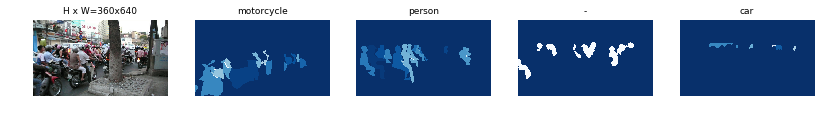

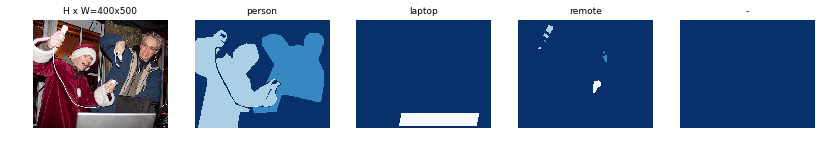

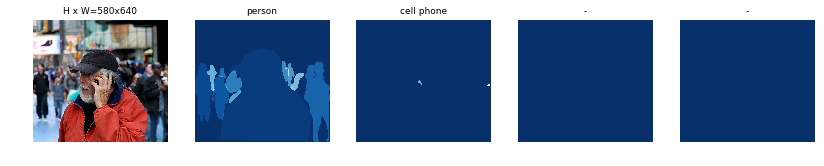

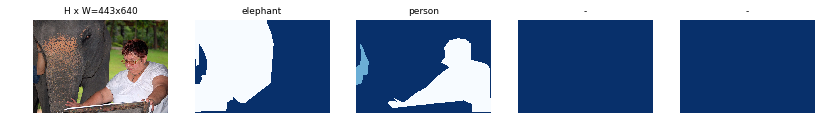

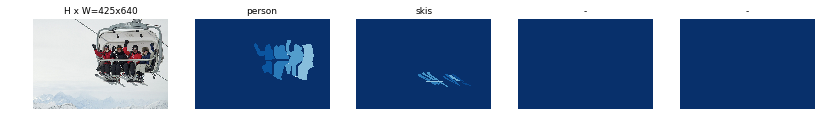

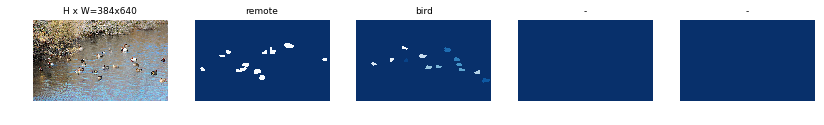

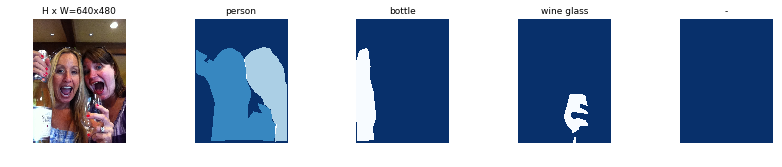

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_test.image_ids, 7)
for image_id in image_ids:
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)

####  Dispaly a random image from dataset_test

image_id  36769 http://cocodataset.org/#explore?id=249715
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000
mask                     shape: (375, 500, 22)        min:    0.00000  max:    1.00000
class_ids                shape: (22,)                 min:  -57.00000  max:   66.00000
bbox                     shape: (22, 4)               min:    1.00000  max:  439.00000
22 22
 display_instances() : Image shape:  (375, 500, 3)


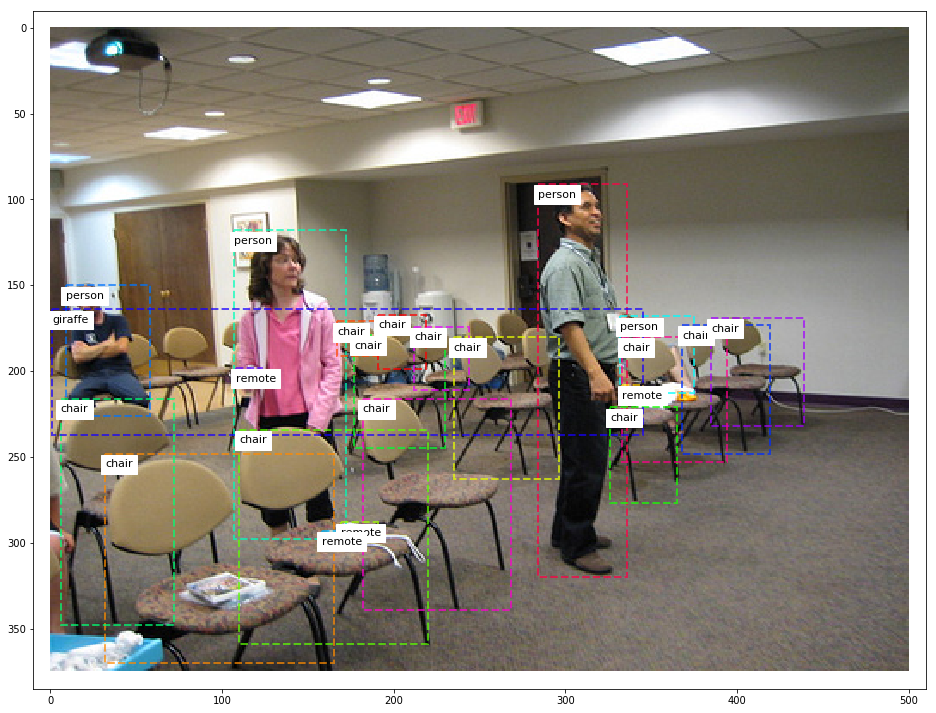

In [8]:
# Load random image and mask. ### 27711 persons and boats
image_id = np.random.choice(dataset_test.image_ids)
image    = dataset_test.load_image(image_id)
mask, class_ids = dataset_test.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_test.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
print(class_ids.shape[0], bbox.shape[0])
# Display image and instances
# visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names)
visualize.display_instances(image, bbox, class_ids, dataset_test.class_names)

### Get next image from generator and display 

#### Get an image and place into train_batch_x

In [16]:
# test_batch_x, test_batch_y = next(test_generator)
# 18045 -- person     36769 -- people in meeting room with a 'giraffe'detection?
#  8634 -- person
# 30531 -- tennis players 
# 8645
from mrcnn.datagen import data_gen_simulate
# test_batch_x, test_batch_y = data_gen_simulate(dataset_test, mrcnn_config, 36769) 
test_batch_x, test_batch_y = data_gen_simulate(dataset_test, mrcnn_config, 30531)

 Converted to image index -->  [30531]
 batch size is : 1
 load image ud:  30531


#### Display test_batch_x image

Image id:  30531
Image meta [30531   427   640     3   170     0   853  1024     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1]
Class_ids shape  (25,)
Class_ids : [39  1  1  1  1  1  1  1 57 57 57 57 57 57 57  1  1  1  1  1 57 57 57 57 39]
(25, 4) (25,)


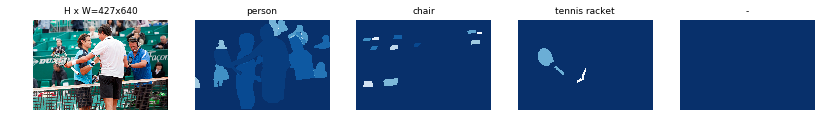

 display_instances() : Image shape:  (427, 640, 3)


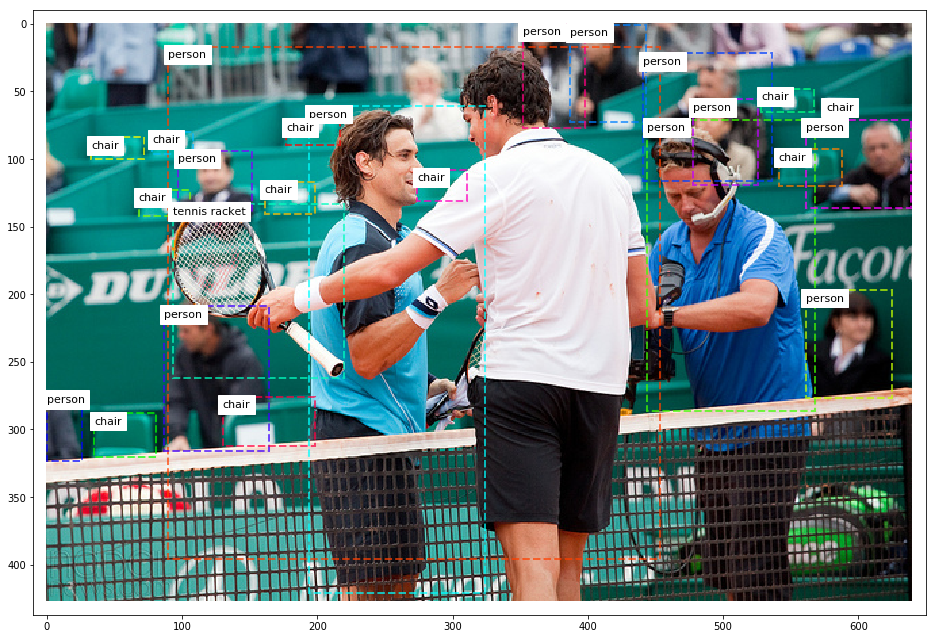

In [17]:
### Display loaded shapes
# test_batch_x, test_batch_y = next(test_generator)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = test_batch_x[imgmeta_idx]
class_names = dataset_test.class_names
for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_test.load_image(image_id)
    mask, class_ids = dataset_test.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)

    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Class_ids shape ',class_ids.shape)
    print('Class_ids :',class_ids)
    print(bbox.shape, class_ids.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_test.class_names)
    # visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_test.class_names)
    visualize.display_instances(image, bbox[:-1,:], class_ids[:-1], dataset_test.class_names)

### Call predict function on image

In [18]:
results = mrcnn_model.detect([image], verbose=1)
r = results[0]
print('  rois       : ', r['rois'])
print('  class ids  : ', r['class_ids'])
print('  class names: ', dataset_test.class_names)
print('  scores     : ', r['scores'])

Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
    Wrapper for Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
     mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
     mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'numpy.ndarray'>
     image_meta         : (1, 89) <class 'numpy.ndarray'>


 Detections are:
[[ 216.      277.      853.      729.        1.        0.9995]
 [ 400.      150.      570.      336.       39.        0.9948]
 [ 502.      133.      679.      265.        1.        0.9915]
 [ 293.      707.      764.      915.        1.        0.9869]
 [ 171.      625.      285.      715.        1.        0.9757]
 [ 217.      416.      308.      495.        1.        0.9696]
 [ 485.    

[20 21 22 23 24 25]
 display_instances() : Image shape:  (427, 640, 3)


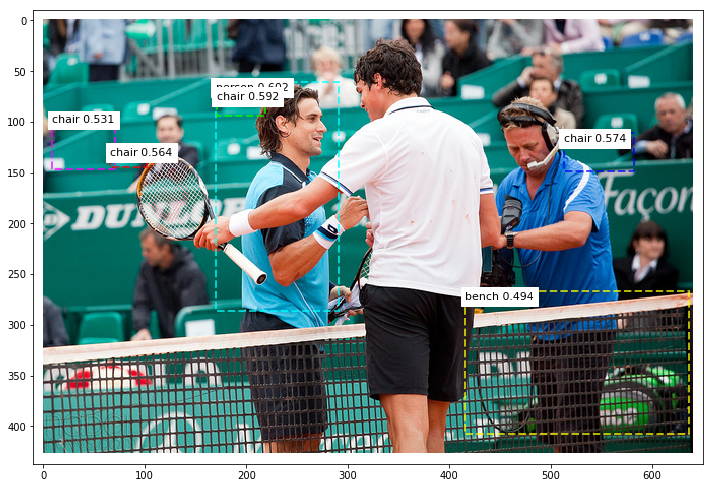

In [22]:
bbox_ixs = np.arange(20,26)
print(bbox_ixs)
# print(r['scores'][bbox_ixs])
visualize.display_instances(image, r['rois'][bbox_ixs], r['class_ids'][bbox_ixs], 
                            dataset_test.class_names, r['scores'][bbox_ixs], ax=visualize.get_ax(size=12))

###  Print some model information 

In [23]:
mrcnn_model.layer_info()



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)


 Outputs:
 --------
 layer:  0    output name: mrcnn_detection/PyFunc:0                   Type: float32           Shape: <unknown>
 layer:  1    output name: ROI/rpn_roi_proposals:0                    Type: float32           Shape: (1, ?, ?)
 layer:  2    output name: mrcnn_class/Reshape_1:0                    Type: float32           Shape: (?, 1000, 81)
 layer:  3    output name: mrcnn_bbox/Reshape:0                       Type: float32           Shape: (?, 1000, 81, 4)


### Push Data thru model using get_layer_output()

In [24]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)

model_output = get_layer_output_1(mrcnn_model.keras_model, test_batch_x, [0,1,2,3], 1, verbose = True)

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
    Wrapper for Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, 1000, 4) <class 'numpy.ndarray'>
     mrcnn_class.shape  : (1, 1000, 81) <class 'numpy.ndarray'>
     mrcnn_bboxes.shape : (1, 1000, 81, 4) <class 'numpy.ndarray'>
     image_meta         : (1, 89) <class 'numpy.ndarray'>


 Detections are:
[[ 216.      277.      853.      729.        1.        0.9995]
 [ 400.      150.      570.      336.       39.        0.9948]
 [ 502.      133.      679.      265.        1.        0.9915]
 [ 293.      707.      764.      915.        1.        0.9869]
 [ 171.      625.      285.      715.        1.        0.9757]
 [ 217.      416.      308.      495.        1.        0.9696]
 [ 485.      904.      614.     1004.        1.        0.9684]
 [ 171.      549.      293.      639.        1.  

### Display output from model

#### Display input_data

In [25]:
# del input_image, input_image_meta, input_gt_class_ids, input_gt_bboxes #, input_gt_bboxes_norm
input_image      =  test_batch_x[0]
input_image_meta =  test_batch_x[1]

print(input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
print('height/width', h,w)
print(' Input image shape is    :', input_image.shape)
print(' input_image_meta        :', input_image_meta)

# input_gt_bboxes_norm = input_gt_bboxes / [h,w,h,w]
# input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

(1, 1024, 1024, 3)
height/width 1024 1024
 Input image shape is    : (1, 1024, 1024, 3)
 input_image_meta        : [[30531   427   640     3   170     0   853  1024     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1     1     1     1     1     1     1     1
      1     1     1     1     1     1     1     1     1]]


#### Display Output Data

In [26]:
print(len(model_output))
# del mrcnn_detection, rpn_roi_proposals, mrcnn_class, mrcnn_bbox
mrcnn_detection           = model_output[0]          # layer:  0   shape: (1, 100, 6)
rpn_roi_proposals         = model_output[1]          # layer:  1   shape: (1, 1000, 4)
mrcnn_class               = model_output[2]          # layer:  2   shape: (1, 1000, 81)
mrcnn_bbox                = model_output[3]          # layer:  3   shape: (1, 1000, 81, 4)
# pred_heatmap_norm         = model_output[4]          # layer:  4   shape: (1, 256, 256, 81)
# pred_heatmap_scores       = model_output[5]          # layer:  5   shape: (1, 81, 100, 11)
# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)

4
(1, 100, 6)
(1, 1000, 4)
(1, 1000, 81)
(1, 1000, 81, 4)


#### mrcnn_class

In [28]:
print(mrcnn_bbox[0,:2].shape) 
print('mrcnn_class shape:', mrcnn_class.shape)
print('mrcnn_bbox shape :', mrcnn_bbox.shape)
pred_scores  = np.max(mrcnn_class,axis = -1)
pred_classes = np.argmax(mrcnn_class,axis = -1)
# pred_classes_2 = np.take(out_mrcnn_bbox, pred_classes, axis = 2)  
print(pred_classes.shape)
print(pred_classes[0])

# print(mrcnn_bbox[0,0])

# pred_bboxes  = mrcnn_bbox[:, pred_classes]
# print('pred_scores shape:', pred_scores.shape)
# print('pred_classes shape:', pred_classes.shape)
# print('pred_bboxes shape:', pred_scores.shape)
# print(mrcnn_bbox.shape)
# print(pred_bboxes.shape)
# print(pred_bboxes[0,:10])


# print(' pred_scores \n',pred_scores)
# print(' pred_classes \n', pred_classes)
# for cls,score in zip(pred_classes,pred_scores):
#     print(' {:3d} {:.<20s} {:4f} '.format(cls, class_names[cls],score))


(2, 81, 4)
mrcnn_class shape: (1, 1000, 81)
mrcnn_bbox shape : (1, 1000, 81, 4)
(1, 1000)
[ 1 39  1  1  1  1  1  1 57  1  0 39  0 39  1  1  1  1 57  1  1  1  1  0  1  1  0 39  1  1  1  1  1
  1  1  1  1  1 39  1 39  1 39  1 39  0  1  0  1  1  0 57  0  1  1  0 39  0  0  0  1 39  0  0  0  0
  0  1  1  0  1  1  0  1  0  0  1  0  1  0 39  1  0  1  0  1  1  0  1 57 57  0  1  0  0  0  0  0  0
  1 57  0  1  0 39  1 57  1  0  0 57  0  1  1 57  1 57  1  1  0 57 57  0  1  0  0  0  0  0  1  0  0
  0  0  0  0  1  1  0 57  1  1  1  0  0  1  1  1  0 39  0 57  1  0 57  0  1  0  1  1  0 39  0  0  0
  1  0  0  0  0  0  1  0 39 39 39  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0 57  1  1  1  0  1  0  0  0  0  0  0  1  1 39  1  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  1  0  0
  0  0  0  0  0  1  1  0  0  0  1  0  0  0  1  1  0  0  0  0 57  0  0  0  0  0  0  0 57  0 57  0  0
  0  0  1 

#### `rpn_roi_proposals`

In [33]:
# print(input_gt_boxes.shape, input_image.shape)
print('output_rois',rpn_roi_proposals.shape, 'deltas ', mrcnn_bbox.shape, 'class_ids ', mrcnn_class.shape)

print(rpn_roi_proposals[0,:20])
print(rpn_roi_proposals[0,:20]*[h,w,h,w])
# print(input_gt_class_ids)
# print(input_normlzd_gt_bboxes)
# print(input_gt_bboxes_norm.shape)
# print(rpn_roi_proposals.shape)

output_rois (1, 1000, 4) deltas  (1, 1000, 81, 4) class_ids  (1, 1000, 81)
[[0.278  0.8865 0.3905 1.    ]
 [0.3517 0.1486 0.5739 0.3634]
 [0.2125 0.7034 0.3516 0.8409]
 [0.4754 0.88   0.5974 0.9847]
 [0.4947 0.1265 0.6545 0.265 ]
 [0.3889 0.6584 0.8481 1.    ]
 [0.1654 0.6089 0.2788 0.6991]
 [0.3024 0.1281 0.4263 0.2523]
 [0.6188 0.0488 0.6646 0.1239]
 [0.3141 0.6972 0.7112 0.8821]
 [0.1645 0.1035 0.6996 0.5705]
 [0.3754 0.1293 0.607  0.3497]
 [0.2438 0.0731 0.6844 0.4698]
 [0.3977 0.1498 0.5483 0.3276]
 [0.1678 0.5333 0.2881 0.6306]
 [0.2194 0.3737 0.833  0.7151]
 [0.2533 0.6605 0.8735 0.9155]
 [0.2485 0.1853 0.895  0.5274]
 [0.3149 0.8413 0.3551 0.9232]
 [0.2136 0.4093 0.2991 0.4884]]
[[ 284.7126  907.7883  399.8981 1024.    ]
 [ 360.1845  152.1188  587.6312  372.1338]
 [ 217.6266  720.2396  359.9909  861.0724]
 [ 486.7986  901.0884  611.7322 1008.3397]
 [ 506.6054  129.5454  670.1887  271.3727]
 [ 398.2017  674.1671  868.5039 1024.    ]
 [ 169.3405  623.4933  285.5052  715.9276]
 [ 

## simulation of mrcnn model `Detect()` routine

###  `unmold_detections()`

In [ ]:

# def unmold_detections(self, detections, mrcnn_mask, image_shape, window):
def unmold_detections( detections, image_shape, window):
    '''
    Reformats the detections of one image from the format of the neural
    network output to a format suitable for use in the rest of the application.

    Input:
    --------
    detections  : [N, (y1, x1, y2, x2, class_id, score)]
    mrcnn_mask  : [N, height, width, num_classes]
    image_shape : [height, width, depth] Original size of the image before resizing
    window      : [y1, x1, y2, x2] Box in the image where the real image is
                   (i.e.,  excluding the padding surrounding the real image)

    Returns:
    --------
    boxes       : [N, (y1, x1, y2, x2)] Bounding boxes in pixels
    class_ids   : [N] Integer class IDs for each bounding box
    scores      : [N] Float probability scores of the class_id
    --- masks       : [height, width, num_instances] Instance masks
    '''

    # print('>>>  unmold_detections ')
    # print('     detections.shape : ', detections.shape)
    # print('     mrcnn_mask.shape : ', mrcnn_mask.shape)
    # print('     image_shape.shape: ', image_shape)
    # print('     window.shape     : ', window)
    # print(detections)

    # How many detections do we have?
    # Detections array is padded with zeros. detections[:,4] identifies the class 
    # Find all rows in detection array with class_id == 0 , and place their row indices
    # into zero_ix. zero_ix[0] will identify the first row with class_id == 0.
    print()
    np.set_printoptions(linewidth=100)        

    zero_ix = np.where(detections[:, 4] == 0)[0]
    N = zero_ix[0] if zero_ix.shape[0] > 0 else detections.shape[0]

#     print(' np.where() \n', np.where(detections[:, 4] == 0))
    print('     zero_ix.shape     : ', zero_ix.shape)
    print('     N is :', N)

    # Extract boxes, class_ids, scores, and class-specific masks
    boxes     = detections[:N,:4]
    class_ids = detections[:N, 4].astype(np.int32)
    scores    = detections[:N, 5]
    # masks     = mrcnn_mask[np.arange(N), :, :, class_ids]

    # Compute scale and shift to translate coordinates to image domain.
    h_scale = image_shape[0] / (window[2] - window[0])
    w_scale = image_shape[1] / (window[3] - window[1])
    scale   = min(h_scale, w_scale)
    shift   = window[:2]  # y, x
    scales = np.array([scale, scale, scale, scale])
    shifts = np.array([shift[0], shift[1], shift[0], shift[1]])

    # Translate bounding boxes to image domain
    boxes = np.multiply(boxes - shifts, scales).astype(np.int32)

    # Filter out detections with zero area. Often only happens in early
    # stages of training when the network weights are still a bit random.
    exclude_ix = np.where(
        (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) <= 0)[0]

    if exclude_ix.shape[0] > 0:
        boxes     = np.delete(boxes    , exclude_ix, axis=0)
        class_ids = np.delete(class_ids, exclude_ix, axis=0)
        scores    = np.delete(scores   , exclude_ix, axis=0)
        # masks     = np.delete(masks, exclude_ix, axis=0)
        N         = class_ids.shape[0]
    print('     After suppression of zero area bboxes, N is :', N)
    # Resize masks to original image size and set boundary threshold.
    # full_masks = []
    # for i in range(N):
        # Convert neural network mask to full size mask
        # full_mask = utils.unmold_mask(masks[i], boxes[i], image_shape)
        # full_masks.append(full_mask)
    # full_masks = np.stack(full_masks, axis=-1)\
        # if full_masks else np.empty((0,) + masks.shape[1:3])

    return boxes, class_ids, scores     # , full_masks

### `detect()`  - Prepare image to pass to model prediction

In [ ]:
input_images = [image]
verbose = True
##-------------------------------------------------------------------------------------        
#     def detect(self, images, verbose=0):
'''
Runs the detection pipeline.

images:         List of images, potentially of different sizes.

Returns a list of dicts, one dict per image. The dict contains:

rois:           [N, (y1, x1, y2, x2)] detection bounding boxes
class_ids:      [N] int class IDs
scores:         [N] float probability scores for the class IDs
masks:          [H, W, N] instance binary masks
'''

# print('>>> model detect()')

assert  mrcnn_model.mode   == "inference", "Create model in inference mode."
assert len(input_images) == mrcnn_model.config.BATCH_SIZE, "len(images) must be equal to BATCH_SIZE"
# print('----compile model ------')
# self.keras_model.compile()

if verbose:
    log("Processing {} images".format(len(input_images)))
    for image in input_images:
        log("image", image)

# Mold inputs to format expected by the neural network
molded_images, image_metas, windows = mrcnn_model.mold_inputs(input_images)
print(windows)
if verbose:
    log("molded_images", molded_images)
    log("image_metas"  , image_metas)

### `Detect( )` pass image to `mrcnn_model.predict()`

In [ ]:
## Run object detection pipeline 
detections, rpn_roi_proposals, mrcnn_class, mrcnn_bbox =  \
          mrcnn_model.keras_model.predict([molded_images, image_metas], verbose=0)

print('    return from  predict()')
print('    Length of detections : ', len(detections), detections.shape)
# print('    detections \n', detections)
print('    Length of rpn_roi_proposals   : ', len(rpn_roi_proposals   ), rpn_roi_proposals.shape)
print('    Length of mrcnn_class: ', len(mrcnn_class), mrcnn_class.shape)
print('    Length of mrcnn_bbox : ', len(mrcnn_bbox ), mrcnn_bbox.shape)
print('                  window : ', len(windows), windows.shape, windows)
# Process detections

### `detect( )` - Prepare output of model prediction for display by calling `unmold_detections()`

In [ ]:
results = []
for i, image in enumerate(input_images):
    # , final_masks =\
    # final_rois, final_class_ids, final_scores, \
    # final_pre_scores, final_fcn_scores          \
      # =  self.unmold_detections_new(fcn_hm_scores[i],        # detections[i], 
                               # image.shape  ,
                               # windows[i])    
   # mrcnn_mask[i],

    final_rois, final_class_ids, final_scores = unmold_detections(detections[i], image.shape, windows[i])    
      # =  self.unmold_detections_new(fcn_hm_scores[i], image.shape, windows[i])    

    results.append({
        "rois"        : final_rois,
        "class_ids"   : final_class_ids,
        "scores"      : final_scores
        # "pre_scores"  : final_pre_scores,
        # "fcn_scores"  : final_fcn_scores,
        # "pre_hm_norm" : pr_hm_norm
        # 'fcn_hm_norm' : fcn_hm_norm,
        # 'fcn_hm'      : fcn_hm
        # "masks"    : final_masks,
    })
    
    # return results     

### Display results

In [ ]:
r = results[0]
print('  rois       : ', r['rois'])
print('  class ids  : ', r['class_ids'])
print('  scores     : ', r['scores'])
print('  class names: ', dataset_test.class_names)


## `Detection_Layer`

###  Setup tensors to be passed to `detections_target_graph()`

This is passed to the DetectionTargetLayer

    detections = DetectionLayer(config, name="mrcnn_detection")\
                                        ([rpn_proposal_rois, mrcnn_class, mrcnn_bbox, input_image_meta])

In [233]:
import mrcnn.utils  as utils
# from mrcnn.detect_layer import overlaps_graph_mod

# try:
#     sess.close()
#     print('session was deleted ')
# except:
#     print('Session was not defined ')
#     pass
# sess = tf.InteractiveSession()

sess = KB.get_session()

# image_id    = 0
# rois        = out_rpn_roi_proposals
# mrcnn_class = out_mrcnn_class
# mrcnn_bboxes= out_mrcnn_bbox
# image_meta  = input_image_meta
# config      = mrcnn_model.config

inputs = [rpn_roi_proposals, mrcnn_class, mrcnn_bbox, input_image_meta]

    No current tf default session 
    tf session initiated:  <tensorflow.python.client.session.Session object at 0x7f77e02b6c88>


In [234]:
with  sess.as_default():
#     rois        = rpn_roi_proposals
#     mrcnn_class = mrcnn_class
#     mrcnn_bbox  = mrcnn_bbox1
#     image_meta  = input_image_meta
#     config      = mrcnn_model.config

#     rois   = KB.identity(rpn_roi_proposals)
#     mrcnn_class = KB.identity(mrcnn_class)
#     mrcnn_bbox  = KB.cast(KB.identity(input_gt_bboxes_norm), dtype='float32')[image_id]
#     mrcnn_bbox = KB.identity(mrcnn_bbox1)

    print(rpn_roi_proposals.dtype, mrcnn_class.dtype, mrcnn_bbox.dtype)
    print(type(rpn_roi_proposals), rpn_roi_proposals.shape)
    print(type(mrcnn_class), mrcnn_class.shape)
    print(type(mrcnn_bbox) , mrcnn_bbox.shape)

    print('    Detection Layer : call() ', type(inputs), len(inputs))    
    print('     rpn_proposals_roi  :',  inputs[0].shape )
    print('     mrcnn_class.shape  :',  inputs[1].shape ) 
    print('     mrcnn_bboxes.shape :',  inputs[2].shape )
    print('     input_image_meta   :',  inputs[3].shape )     


float32 float32 float32
<class 'numpy.ndarray'> (1, 1000, 4)
<class 'numpy.ndarray'> (1, 1000, 81)
<class 'numpy.ndarray'> (1, 1000, 81, 4)
    Detection Layer : call()  <class 'list'> 4
     rpn_proposals_roi  : (1, 1000, 4)
     mrcnn_class.shape  : (1, 1000, 81)
     mrcnn_bboxes.shape : (1, 1000, 81, 4)
     input_image_meta   : (1, 89)


### def `dev_detection_graph`

Copied from detection_layer_mod on 09/17/2018

####  Simulate loop calling `refine detections() `

In [236]:
img_idx = 0 
_, _, window, _ =  parse_image_meta(input_image_meta)
rois   = rpn_roi_proposals[img_idx]
probs  = mrcnn_class[img_idx]
deltas = mrcnn_bbox[img_idx] 
window = window[img_idx]
config = mrcnn_config

# def refine_detections(rois, probs, deltas, window, config):

##----------------------------------------------------------------------------
##  1. Find Class IDs with higest scores for each per ROI
##----------------------------------------------------------------------------
class_ids       = np.argmax(probs, axis=1)
print('probs shape: {}   deltas.shape {}  rois.shape{} '.format(probs.shape,deltas.shape, rois.shape))


##----------------------------------------------------------------------------
##  2. Get Class probability(score) and bbox delta of the top class of each ROI
##----------------------------------------------------------------------------
class_scores    =  probs[np.arange(class_ids.shape[0]), class_ids]
deltas_specific = deltas[np.arange(deltas.shape[0])   , class_ids]

#display
print('class_ids shape', class_ids.shape, '  class_scores.shape: ',class_scores.shape)
print(class_ids[:5],'   ',class_scores[:5])

# display some of the argmax classes and scores 
indexes = np.concatenate([np.arange(5),np.arange(37,45)])
print(indexes)
print(probs[:5,indexes])

# display some of the argmax classes bboxes
print(' deltas_specific ', deltas_specific.shape)
# print(deltas_specific[:5])
# print(deltas[:5, indexes])


##----------------------------------------------------------------------------
##  3. Apply bounding box delta to the corrsponding rpn_proposal
##----------------------------------------------------------------------------
# Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
refined_rois    = utils.apply_box_deltas_np(rois, deltas_specific * config.BBOX_STD_DEV)

print('rois ', rois.shape,'    refined_rois shape: ',refined_rois.shape)
print('\nrois - unadjusted ')
print(rois[:5])
print('\nadjustments ')
print(deltas_specific[:5])
print('\nrois - adjusted ')
print(refined_rois[:10])
##----------------------------------------------------------------------------
##  4. Convert the refined roi coordiates from normalized to image domain
##----------------------------------------------------------------------------
# TODO: better to keep them normalized until later   
height, width   = config.IMAGE_SHAPE[:2]
refined_rois   *= np.array([height, width, height, width])

print(window)
print('\nrois - adjusted / image_domain')
print(refined_rois[:20])


probs shape: (1000, 81)   deltas.shape (1000, 81, 4)  rois.shape(1000, 4) 
class_ids shape (1000,)   class_scores.shape:  (1000,)
[39 57  1  1  1]     [0.9958 0.9753 0.9726 0.9775 0.9668]
[ 0  1  2  3  4 37 38 39 40 41 42 43 44]
[[0.0022 0.0004 0.0001 0.     0.     0.     0.     0.9958 0.     0.     0.     0.     0.    ]
 [0.0235 0.0005 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0267 0.9726 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0208 0.9775 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.033  0.9668 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
 deltas_specific  (1000, 4)
rois  (1000, 4)     refined_rois shape:  (1000, 4)

rois - unadjusted 
[[0.3662 0.1418 0.5788 0.362 ]
 [0.6178 0.0491 0.6636 0.1228]
 [0.2806 0.8858 0.3865 0.9996]
 [0.21   0.7013 0.3499 0.8381]
 [0.4744 0.8817 0.596  0.9801]]

adjustments 
[[ 0.1515 -0.2577 -0.4469 -0.14

In [238]:
# print(window)
# test_box = np.array([[10,10,40,40]])
# print(test_box.shape)
# print(clip_to_window(window,test_box))

##----------------------------------------------------------------------------
##  5.  Clip boxes to image window
##----------------------------------------------------------------------------
refined_rois    = clip_to_window(window, refined_rois)


##----------------------------------------------------------------------------
##  6.  Round and cast to int since we're deadling with pixels now
##----------------------------------------------------------------------------
refined_rois    = refined_rois.astype(np.int32)
print(refined_rois[:20])

(1000, 4)
[[ 387  142  586  361]
 [ 631   50  680  127]
 [ 283  909  393 1021]
 [ 219  720  357  854]
 [ 489  902  609 1001]
 [ 289  704  754  909]
 [ 319  863  356  940]
 [ 213  270  853  714]
 [ 500  133  677  263]
 [ 170  625  284  714]
 [ 531  456  642  516]
 [ 290  694  850  925]
 [ 223  719  359  853]
 [ 310  136  423  248]
 [ 170  552  293  638]
 [ 388  144  580  358]
 [ 269  708  820  913]
 [ 270   67  682  466]
 [ 269  702  810  923]
 [ 273  264  853  518]]


#### Create a table of refined_rois, class_ids and class_scores for display

In [239]:
# print(refined_rois[:100])
for_display = np.concatenate((refined_rois, np.expand_dims(class_ids,axis =-1), np.expand_dims(class_scores,axis=-1)), axis=-1)
print(for_display.shape)
print(refined_rois.shape)
print(class_scores[:5], class_ids[:5])
print(for_display[100:200])
bgidxs = np.where(class_ids > 0)[0]
for_display_nz = for_display[keep,:]
print(for_display_nz.shape)
print(for_display_nz)


(1000, 6)
(1000, 4)
[0.9958 0.9753 0.9726 0.9775 0.9668] [39 57  1  1  1]
[[ 388.      249.      434.      349.       57.        0.6459]
 [ 320.      862.      356.      943.       57.        0.9654]
 [ 228.        0.      688.      377.        0.        0.9713]
 [ 370.      107.      398.      161.       57.        0.801 ]
 [ 664.      107.      747.      308.        0.        0.6123]
 [ 624.        5.      751.      130.        0.        0.8476]
 [ 359.      825.      408.      941.        0.        0.5095]
 [ 617.      205.      668.      317.       57.        0.5668]
 [ 614.      194.      745.      316.        0.        0.4778]
 [ 479.      531.      818.     1011.        0.        0.8299]
 [ 607.        0.      693.       46.        1.        0.8717]
 [ 270.      261.      710.      487.        1.        0.5047]
 [ 228.        4.      285.       71.        0.        0.7183]
 [ 170.      470.      654.      966.        0.        0.9357]
 [ 606.      449.      639.      481.       

In [240]:
##----------------------------------------------------------------------------
##  8.  Filter out boxes with class == background and low confidence score 
##      (boxes with class_scores < DETECTION_MIN_CONFIDENCE)
##      keep : contains indices of non-zero elements in class_ids
##      config.DETECTION_MIN_CONFIDENCE == 0 
##----------------------------------------------------------------------------
keep = np.where(class_ids > 0)[0]
# Filter out low confidence boxes
if config.DETECTION_MIN_CONFIDENCE:
    keep = np.intersect1d(keep, np.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[0])

pre_nms_class_ids = class_ids[keep]
pre_nms_scores    = class_scores[keep]
pre_nms_rois      = refined_rois[keep]
# print(class_ids)
print(keep.shape, keep)

print(pre_nms_class_ids.shape, pre_nms_rois.shape, pre_nms_scores.shape)

(292,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  18  19  20  21  22  23  24
  25  26  28  29  30  31  32  33  35  36  37  38  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  56  59  60  62  63  64  67  68  70  71  72  74  75  78  79  80  81  82  85  86  88  89
  93  94  97  98  99 100 101 103 107 110 111 115 116 117 118 119 121 124 126 128 129 133 134 137
 138 142 145 146 148 152 153 154 158 160 162 163 164 167 169 170 171 172 173 174 175 177 181 182
 183 187 189 190 191 192 195 196 198 201 203 204 207 212 214 216 219 228 229 230 232 235 236 237
 239 240 242 243 244 247 251 252 259 260 268 271 273 278 279 281 282 285 288 292 299 300 301 302
 308 310 312 315 318 319 327 329 330 332 343 346 347 352 354 356 367 371 383 384 396 405 411 412
 414 416 417 429 436 438 444 448 452 453 455 464 465 468 472 477 479 480 483 485 500 504 511 513
 519 520 525 529 534 538 541 562 571 574 576 588 604 607 608 611 613 616 617 619 622 626 631 632
 636 659 675 677 678 68

####  TODO: Code to suppress very small bounding boxes 

In [139]:
# print(refined_rois[:100])
print(pre_nms_rois.shape)
##----------------------------------------------------------------------------
##  7.  TODO: Filter out boxes with area smaller than DETECTION_MIN_AREA == 50
##----------------------------------------------------------------------------
pre_nms_rois_area = (pre_nms_rois[:,2]-pre_nms_rois[:,0]) * (pre_nms_rois[:,3]-pre_nms_rois[:,1])
keep1 = np.where(pre_nms_rois_area > 50)[0]
pre_nms_class_ids = class_ids[keep1]
pre_nms_scores    = class_scores[keep1]
pre_nms_rois      = refined_rois[keep1]


print(pre_nms_rois_area.shape)
print(pre_nms_rois_area)
keep2 = np.where(pre_nms_rois_area <= 50)[0]
print(keep1)
print(keep2)
print(pre_nms_rois_area[keep1])
print(np.unique(pre_nms_class_ids))

(111, 4)
(111,)
[ 17100  14792  13440 267156 335907 270474  16235  17336  38046  37544  30600 280440 309540  14028
  35420 115551  13527  17381  13840  33120  38250 261800 263506  32886  14181 320320 263865 322630
  26709  13612 275250  16269  13448  14344  31648 357698 275632 244397  39732  34310   6256 265300
 272800 293376 224442   7049   7332 296378  19303  21321  13846   5376  13770  16280 312983  36089
  13475 305744  14442  12450  35040 105096  14022  18336 309412 134750 299296  27234  14028 249900
 264180 256296 308100 313752  36414 253230 278240  18721 313831  29575  33748 294513 325125  14256
 292468 320620 338960  16182  12640  11280  15834  16185  19669  14725  41745  13667  18245  29400
 300510  17978  30870  32395  36946  28518  14365  30452   7353  35525  30014  37422   6144]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48

In [241]:
##----------------------------------------------------------------------------
##  9.  Apply per-class NMS
##       config.DETECTION_NMS_THRESHOLD == 0.3
##----------------------------------------------------------------------------
nms_keep          = []
# print(' apply per class nms')    
print('class_id : ', pre_nms_class_ids.shape)
print(pre_nms_class_ids)

for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    print()
    print('class id :', class_id)
    print('----------')

    print('pre_nms_rois.shape   :', pre_nms_rois[ixs].shape)
#     pp.pprint(pre_nms_rois[ixs])
    print('pre_nms_scores.shape :', pre_nms_scores[ixs].shape)
#     pp.pprint(pre_nms_scores[ixs])    

    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_rois[ixs], 
                                     pre_nms_scores[ixs], 0.8)
#                                      config.DETECTION_NMS_THRESHOLD)
    print()
    print('class indexes pre-nms : ', ixs.shape, ixs)
    print()
    print('class indexes post nms: ',class_keep.shape, ixs[class_keep])
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    print('class_keep.shape: {}    nms_keep.shape :{} '.format(len(class_keep), len(nms_keep)))
    nms_keep   = np.union1d(nms_keep, class_keep)
    print('new nms_keep.shape{} '.format(nms_keep.shape))

print(nms_keep)
keep3 = np.intersect1d(keep, nms_keep).astype(np.int32)
print('keep3', keep3.shape, keep3)

class_id :  (292,)
[39 57  1  1  1  1 57  1  1  1 39  1  1  1  1 39  1  1  1  1  1  1  1 39  1 57 39  1  1  1 57 57  1
  1 57  1  1 39  1 39  1  1 39 57  1 57  1  1  1  1 39 57 57 39  1  1 57 57 57 39 57  1 39  1 57  1
 57 57 57  1  1  1  1  1  1 57 57 57 57 57 57  1  1  1  1  1  1  1  1  1 57  1  1  1  1  1 57  1 57
  1 39 57 57 57  1 57  1  1 57  1  1 57 57 57  1  1 57 39  1 57 39 57 57 39  1  1  1 57  1  1 57  1
 39  1 57  1  1  2  1 57 57 39 57  1  1  1 57  1  1  1  1  1 57  1 57  1  1 57 14  1  1  1 57  1  1
 57 39 57  1  1 57 57  1 57 57  1 57 57  1  1 57  1  1  1  1 57  2  1 57  1  1  1  1  1  1 39  2  1
  1 57  1  1  1 57  1  1 57  1 57 57 57  1  1 57  1 57  1  1 57  1 57  1 39 39 39  1 39 57  1  1 57
  1 39 57  1 57 57  1 39 39 57 57  1  1  1  1  1  1  2 39 57  1 57 57  1  1 57 57  1  1  1 57  1 57
 57  1  1 57 57  1 57 57  1  1  1  1 57 57 57  1 57  1 57  1 57 57  1  1  1 39  1  1]

class id : 1
----------
pre_nms_rois.shape   : (161, 4)
pre_nms_scores.shape : (161,)

class i

In [242]:
##----------------------------------------------------------------------------
## 10.  Keep top detections
##----------------------------------------------------------------------------
roi_count = config.DETECTION_MAX_INSTANCES
top_ids   = np.argsort(class_scores[keep3])[::-1][:roi_count]
keep4     = keep3[top_ids]
# print(np.argsort(class_scores[keep3])[::-1])
# print(class_ids[keep3][...,np.newaxis])
print(top_ids)
print(keep4)
print(class_scores[keep4])

[ 7  4  0  2  5 59 39 47 61 18 19 52  1 66 80  3 12 48 13 50 26 79 55 33  6 27 49 65 11 14 67 42 41
 56 23 15 53 76 78 68 36  8 28 84 46 34 73 30 75 60 58 21 37 51 81 57 74 22  9 38 17 70 25 10 45 31
 20 82 72 40 43 24 69 64 29 83 35 16 63 54 77 62 32 44 71]
[ 30  16   0   8  19 452 229 299 455  78  81 347   3 611 864  13  49 308  51 329 116 785 411 163
  22 121 319 562  44  63 613 251 240 412 103  67 354 741 775 619 187  32 129 986 285 164 726 146
 737 453 448  97 196 332 868 417 732  99  35 201  75 688 115  37 281 153  85 917 725 232 273 107
 626 534 145 972 177  68 480 383 771 479 162 279 711]
[0.9994 0.9959 0.9958 0.9956 0.9918 0.9908 0.9864 0.9848 0.9839 0.9812 0.981  0.9801 0.9775 0.9715
 0.9632 0.9467 0.9141 0.9131 0.9111 0.9006 0.8994 0.8987 0.893  0.8836 0.8736 0.8664 0.849  0.8437
 0.8432 0.8321 0.8247 0.8093 0.8054 0.8028 0.801  0.7831 0.7582 0.7434 0.7385 0.7347 0.7167 0.7133
 0.7101 0.6939 0.6894 0.688  0.6741 0.673  0.667  0.6619 0.6467 0.6375 0.6347 0.6238 0.6238 0.6229


In [243]:
##----------------------------------------------------------------------------
## 10.  Keep top detections
##----------------------------------------------------------------------------
roi_count = config.DETECTION_MAX_INSTANCES
top_ids   = np.argsort(class_scores[keep3])[::-1][:roi_count]
keep4     = keep3[top_ids]
# print(np.argsort(class_scores[keep3])[::-1])
# print(class_ids[keep3][...,np.newaxis])
print(top_ids)
print(keep4)
print(class_scores[keep4])

[ 7  4  0  2  5 59 39 47 61 18 19 52  1 66 80  3 12 48 13 50 26 79 55 33  6 27 49 65 11 14 67 42 41
 56 23 15 53 76 78 68 36  8 28 84 46 34 73 30 75 60 58 21 37 51 81 57 74 22  9 38 17 70 25 10 45 31
 20 82 72 40 43 24 69 64 29 83 35 16 63 54 77 62 32 44 71]
[ 30  16   0   8  19 452 229 299 455  78  81 347   3 611 864  13  49 308  51 329 116 785 411 163
  22 121 319 562  44  63 613 251 240 412 103  67 354 741 775 619 187  32 129 986 285 164 726 146
 737 453 448  97 196 332 868 417 732  99  35 201  75 688 115  37 281 153  85 917 725 232 273 107
 626 534 145 972 177  68 480 383 771 479 162 279 711]
[0.9994 0.9959 0.9958 0.9956 0.9918 0.9908 0.9864 0.9848 0.9839 0.9812 0.981  0.9801 0.9775 0.9715
 0.9632 0.9467 0.9141 0.9131 0.9111 0.9006 0.8994 0.8987 0.893  0.8836 0.8736 0.8664 0.849  0.8437
 0.8432 0.8321 0.8247 0.8093 0.8054 0.8028 0.801  0.7831 0.7582 0.7434 0.7385 0.7347 0.7167 0.7133
 0.7101 0.6939 0.6894 0.688  0.6741 0.673  0.667  0.6619 0.6467 0.6375 0.6347 0.6238 0.6238 0.6229


In [246]:
##----------------------------------------------------------------------------
## 11.  Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
##      Coordinates are in image domain.
##----------------------------------------------------------------------------
result = np.hstack((refined_rois[keep4],
                    class_ids   [keep4][..., np.newaxis],
                    class_scores[keep4][..., np.newaxis]))

print(result)

[[ 218.      274.      853.      706.        1.        0.9994]
 [ 269.      708.      820.      913.        1.        0.9959]
 [ 387.      142.      586.      361.       39.        0.9958]
 [ 500.      133.      677.      263.        1.        0.9956]
 [ 273.      264.      853.      518.        1.        0.9918]
 [ 170.      626.      284.      711.        1.        0.9908]
 [ 215.      415.      308.      493.        1.        0.9864]
 [ 284.      911.      395.     1021.        1.        0.9848]
 [ 489.      902.      612.     1001.        1.        0.9839]
 [ 234.      279.      853.      493.        1.        0.9812]
 [ 631.       51.      680.      127.       57.        0.981 ]
 [ 320.      862.      356.      941.       57.        0.9801]
 [ 219.      720.      357.      854.        1.        0.9775]
 [ 170.      546.      291.      641.        1.        0.9715]
 [ 170.      291.      257.      384.        1.        0.9632]
 [ 310.      136.      423.      248.        1.        

In [247]:
print(window)
print(image.shape)
print(result.shape)

[ 170    0  853 1024]
(427, 640, 3)
(85, 6)


In [250]:
results = []
final_rois, final_class_ids, final_scores = mrcnn_model.unmold_detections(result, image.shape, window)    
results.append({
    "rois"        : final_rois,
    "class_ids"   : final_class_ids,
    "scores"      : final_scores
})
# results = mrcnn_model.detect([image], verbose=1)
r = results[0]
 
print('  rois       : ', r['rois'])
print('  class ids  : ', r['class_ids'])
print('  scores     : ', r['scores'])
print('  detections count: ', r['class_ids'].shape[0], result.shape[0])


  rois       :  [[ 30 171 426 441]
 [ 61 442 406 570]
 [135  88 260 225]
 [206  83 316 164]
 [ 64 165 426 323]
 [  0 391  71 444]
 [ 28 259  86 308]
 [ 71 569 140 638]
 [199 563 276 625]
 [ 40 174 426 308]
 [288  31 318  79]
 [ 93 538 116 588]
 [ 30 450 116 533]
 [  0 341  75 400]
 [  0 181  54 240]
 [ 87  85 158 155]
 [ 87  81 218 159]
 [ 89  79 196 160]
 [ 63 180 362 305]
 [ 26 447  96 536]
 [ 72 441 320 565]
 [  0 495  33 555]
 [195  81 337 166]
 [  0 473  35 554]
 [272   0 321  26]
 [ 88  79 271 175]
 [ 84  28 102  71]
 [130  86 247 211]
 [223 287 293 321]
 [  0 441  38 538]
 [127  90 281 220]
 [  0 452  36 555]
 [ 88  78 150 158]
 [ 47 466 118 530]
 [125  66 142 100]
 [115 161 138 216]
 [ 63 438 275 558]
 [201 560 331 626]
 [ 68 174  91 215]
 [136 156 168 215]
 [131 158 164 215]
 [137 158 165 216]
 [  0 435  39 513]
 [ 67 179 332 293]
 [  0 361  75 424]
 [ 81  75  98 110]
 [116 163 137 210]
 [ 66 175 273 286]
 [ 50 526  66 568]
 [203 560 311 630]
 [ 68 171  93 218]
 [272   0 362 

[[ 246.      268.      726.      538.        1.        0.4892]
 [ 602.      701.      834.     1006.       14.        0.4718]
 [ 593.      661.      832.     1024.        2.        0.3355]] ['person', 'bench', 'bicycle']
 display_instances() : Image shape:  (427, 640, 3)


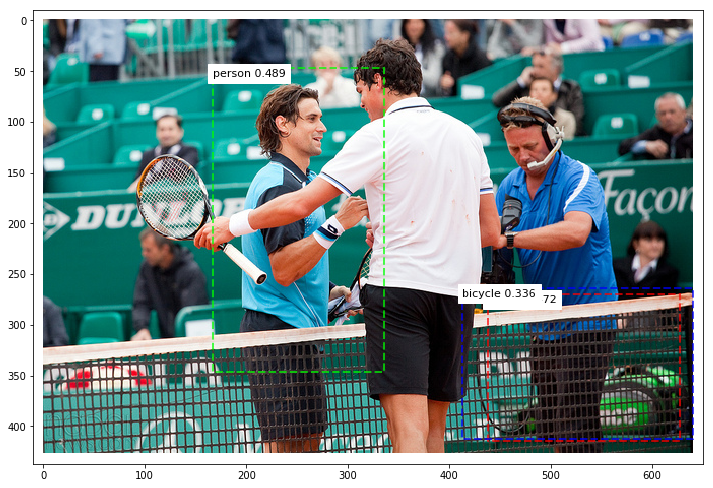

In [262]:
indexes = np.array([6,7,8])
indexes = np.arange(82,85)
print(result[indexes], [dataset_test.class_names[i.astype(int)] for i in result[indexes,-2].astype(int)])
# indexes = np.array(np.arange(8,)
# visualize.display_instances(image, r['rois'][indexes], r['class_ids'][indexes], 
#                             dataset_test.class_names, r['scores'][indexes], ax=visualize.get_ax(size=12))
visualize.display_instances(image, final_rois[indexes], final_class_ids[indexes], 
                            dataset_test.class_names, final_scores[indexes], ax=visualize.get_ax(size=12))

#### `clip_to_window( )`

In [75]:
def clip_to_window(window, boxes):
    '''
    window: (y1, x1, y2, x2). The window in the image we want to clip to.
    boxes: [N, (y1, x1, y2, x2)]
    '''
    print(boxes.shape)
    boxes[:, 0] = np.maximum(np.minimum(boxes[:, 0], window[2]), window[0])
    boxes[:, 1] = np.maximum(np.minimum(boxes[:, 1], window[3]), window[1])
    boxes[:, 2] = np.maximum(np.minimum(boxes[:, 2], window[2]), window[0])
    boxes[:, 3] = np.maximum(np.minimum(boxes[:, 3], window[3]), window[1])
    return boxes

#### `refine_detections()` routine  17-09-2018

In [26]:
def refine_detections(rois, probs, deltas, window, config):
    '''
    Refine classified proposals and filter overlaps and return final detections.

    Inputs:
    ------
        
    rois:           rpn_rois    - [N, (y1, x1, y2, x2)] in normalized coordinates
    probs:          mrcnn_class - [N, num_classes]. Class probabilities.
    deltas:         mrcnn_bbox  - [N, num_classes, (dy, dx, log(dh), log(dw))]. 
                                  Class-specific bounding box deltas.
                                  
    window:         (y1, x1, y2, x2) in image coordinates. The part of the image
                    that contains the image excluding the padding.

    Returns:
    --------
    detections      [N, (y1, x1, y2, x2, class_id, score)]
    '''

    
    ##  1. Find Class IDs with higest scores for each per ROI
    class_ids       = np.argmax(probs, axis=1)
    
    print(class_ids)
    ##  2. Get Class probability(score) and bbox delta of the top class of each ROI
    class_scores    =  probs[np.arange(class_ids.shape[0]), class_ids]
    deltas_specific = deltas[np.arange(deltas.shape[0])   , class_ids]
    
    ##  3. Apply bounding box delta to the corrsponding rpn_proposal
    # Shape: [boxes, (y1, x1, y2, x2)] in normalized coordinates
    refined_rois    = apply_box_deltas(rois, deltas_specific * config.BBOX_STD_DEV)
    
    ##  4. Convert the refined roi coordiates from normalized to image domain
    # TODO: better to keep them normalized until later   
    height, width   = config.IMAGE_SHAPE[:2]
    refined_rois   *= np.array([height, width, height, width])
    
    ##  5.  Clip boxes to image window
    refined_rois    = clip_to_window(window, refined_rois)
    
    ##  6.  Round and cast to int since we're deadling with pixels now
    refined_rois    = np.rint(refined_rois).astype(np.int32)

    ##  7.  TODO: Filter out boxes with zero area

    ##  8.  Filter out background boxes
    keep = np.where(class_ids > 0)[0]
    # Filter out low confidence boxes
    if config.DETECTION_MIN_CONFIDENCE:
        keep = np.intersect1d(keep, np.where(class_scores >= config.DETECTION_MIN_CONFIDENCE)[0])

    ##----------------------------------------------------------------------------
    ##  9.  Apply per-class NMS
    ##----------------------------------------------------------------------------
    pre_nms_class_ids = class_ids[keep]
    pre_nms_scores    = class_scores[keep]
    pre_nms_rois      = refined_rois[keep]
    nms_keep          = []
    # print(' apply per class nms')    
    for class_id in np.unique(pre_nms_class_ids):
        # Pick detections of this class
        ixs = np.where(pre_nms_class_ids == class_id)[0]

        # print('class_id : ', class_id)
        # print('pre_nms_rois.shape:', pre_nms_rois[ixs].shape)
        # pp.pprint(pre_nms_rois[ixs])
        # print('pre_nms_scores.shape :', pre_nms_scores[ixs].shape)
        # pp.pprint(pre_nms_scores[ixs])    
        # Apply NMS
        class_keep = non_max_suppression(pre_nms_rois[ixs], 
                                         pre_nms_scores[ixs],
                                         config.DETECTION_NMS_THRESHOLD)
        # Map indicies
        class_keep = keep[ixs[class_keep]]
        nms_keep   = np.union1d(nms_keep, class_keep)
    
    keep = np.intersect1d(keep, nms_keep).astype(np.int32)

    ##----------------------------------------------------------------------------
    ## 10.  Keep top detections
    ##----------------------------------------------------------------------------
    roi_count = config.DETECTION_MAX_INSTANCES
    top_ids   = np.argsort(class_scores[keep])[::-1][:roi_count]
    keep      = keep[top_ids]

    ##----------------------------------------------------------------------------
    ## 11.  Arrange output as [N, (y1, x1, y2, x2, class_id, score)]
    ##      Coordinates are in image domain.
    ##----------------------------------------------------------------------------
    result = np.hstack((refined_rois[keep],
                        class_ids   [keep][..., np.newaxis],
                        class_scores[keep][..., np.newaxis]))

    return result